In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeRegressor

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [6]:
import lightgbm as lgb

In [7]:
import shap

In [8]:
from sklearn.metrics import mean_absolute_error

In [9]:
import numpy as np

In [10]:
import plotly.graph_objects as go

In [78]:
from plotly.colors import n_colors

In [11]:
df_teams = pd.read_csv('../data/raw/team-seasons-2020-1981.csv')
df_ballots = pd.read_csv('../data/raw/All-NBA-Voting-Ballots.csv')

In [ ]:
df_team_results[df_team_results['Team']== 'LAL']

In [ ]:
df_votes = pd.merge(df_votes,df_team_results,on=['Season','Team'])

df_votes.to_csv('../data/interim/votes-team-merged', index=False)

In [12]:
df_votes = pd.read_csv('../data/interim/votes-team-merged')

In [13]:
df_votes.to_csv('../data/interim/votes-team-merged', index=False)

In [14]:
df_votes = pd.read_csv('../data/interim/votes-team-merged')
df_votes.head()

,Season,Player,Age,Team,First,Pts Won,Pts Max,Share,G,MP,...,BLK,FG%,3P%,FT%,WS,WS/48,W/L%,SRS,Rel ORtg,Rel DRtg
0,2019-20,Giannis Antetokounmpo,25,MIL,85.0,962.0,1010,0.952,63,30.4,...,1.0,0.553,0.304,0.633,11.1,0.279,0.767,9.41,1.8,-7.7
1,2019-20,LeBron James,35,LAL,16.0,753.0,1010,0.746,67,34.6,...,0.5,0.493,0.348,0.693,9.8,0.204,0.732,6.28,1.4,-4.3
2,2019-20,Anthony Davis,26,LAL,0.0,82.0,1010,0.081,62,34.4,...,2.3,0.503,0.330,0.846,11.1,0.250,0.732,6.28,1.4,-4.3
3,2019-20,James Harden,30,HOU,0.0,367.0,1010,0.363,68,36.5,...,0.9,0.444,0.355,0.865,13.1,0.254,0.611,3.13,2.3,-0.5
4,2019-20,Luka Dončić,20,DAL,0.0,200.0,1010,0.198,61,33.6,...,0.2,0.463,0.316,0.758,8.8,0.207,0.573,4.87,6.1,1.1


In [15]:
df_votes['Net Rtg'] = df_votes.apply(lambda df: df['Rel ORtg'] - df['Rel DRtg'], axis=1)

In [16]:
def plotCorrelationMatrix(df, graphWidth, filename = ''):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

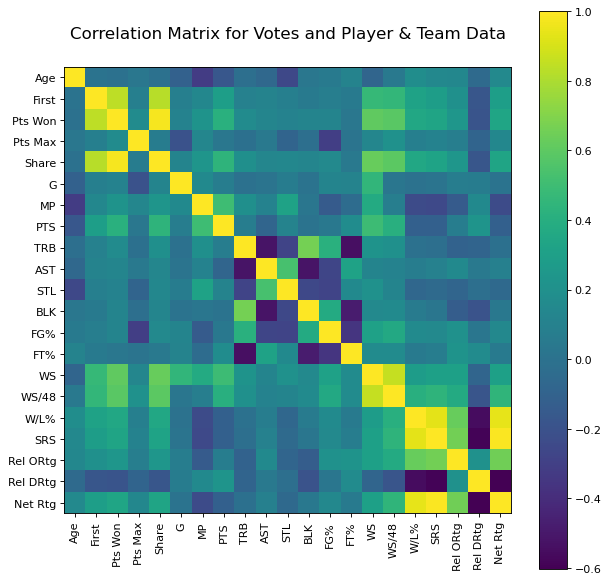

In [17]:
plotCorrelationMatrix(df_votes,9, 'Votes and Player & Team Data')

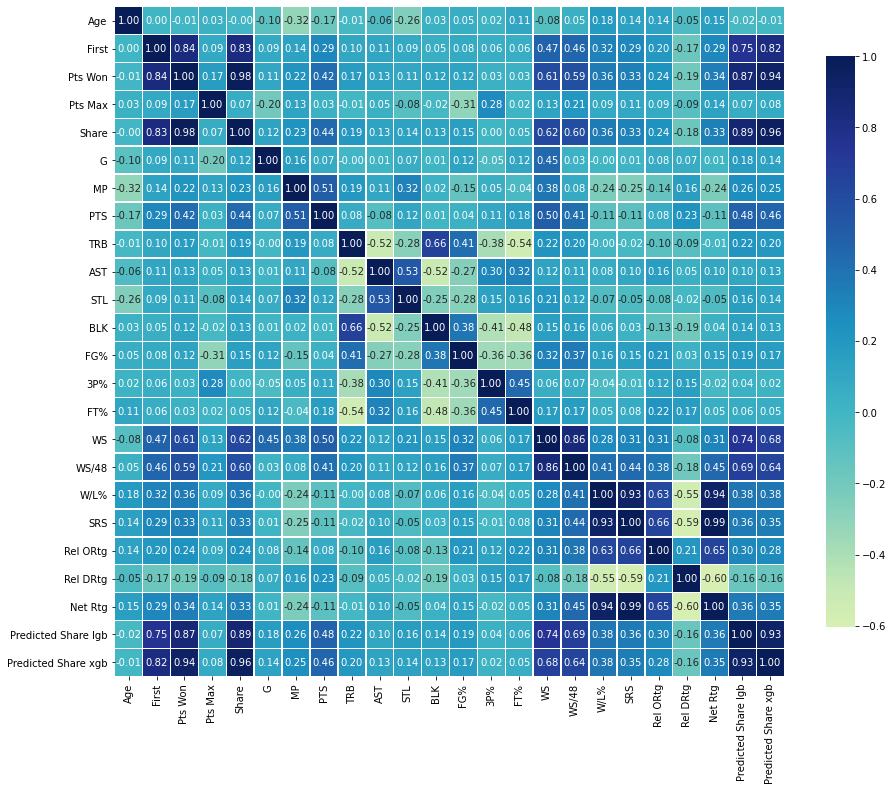

In [105]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sn.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(df_votes)

In [18]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    '''
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    '''
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

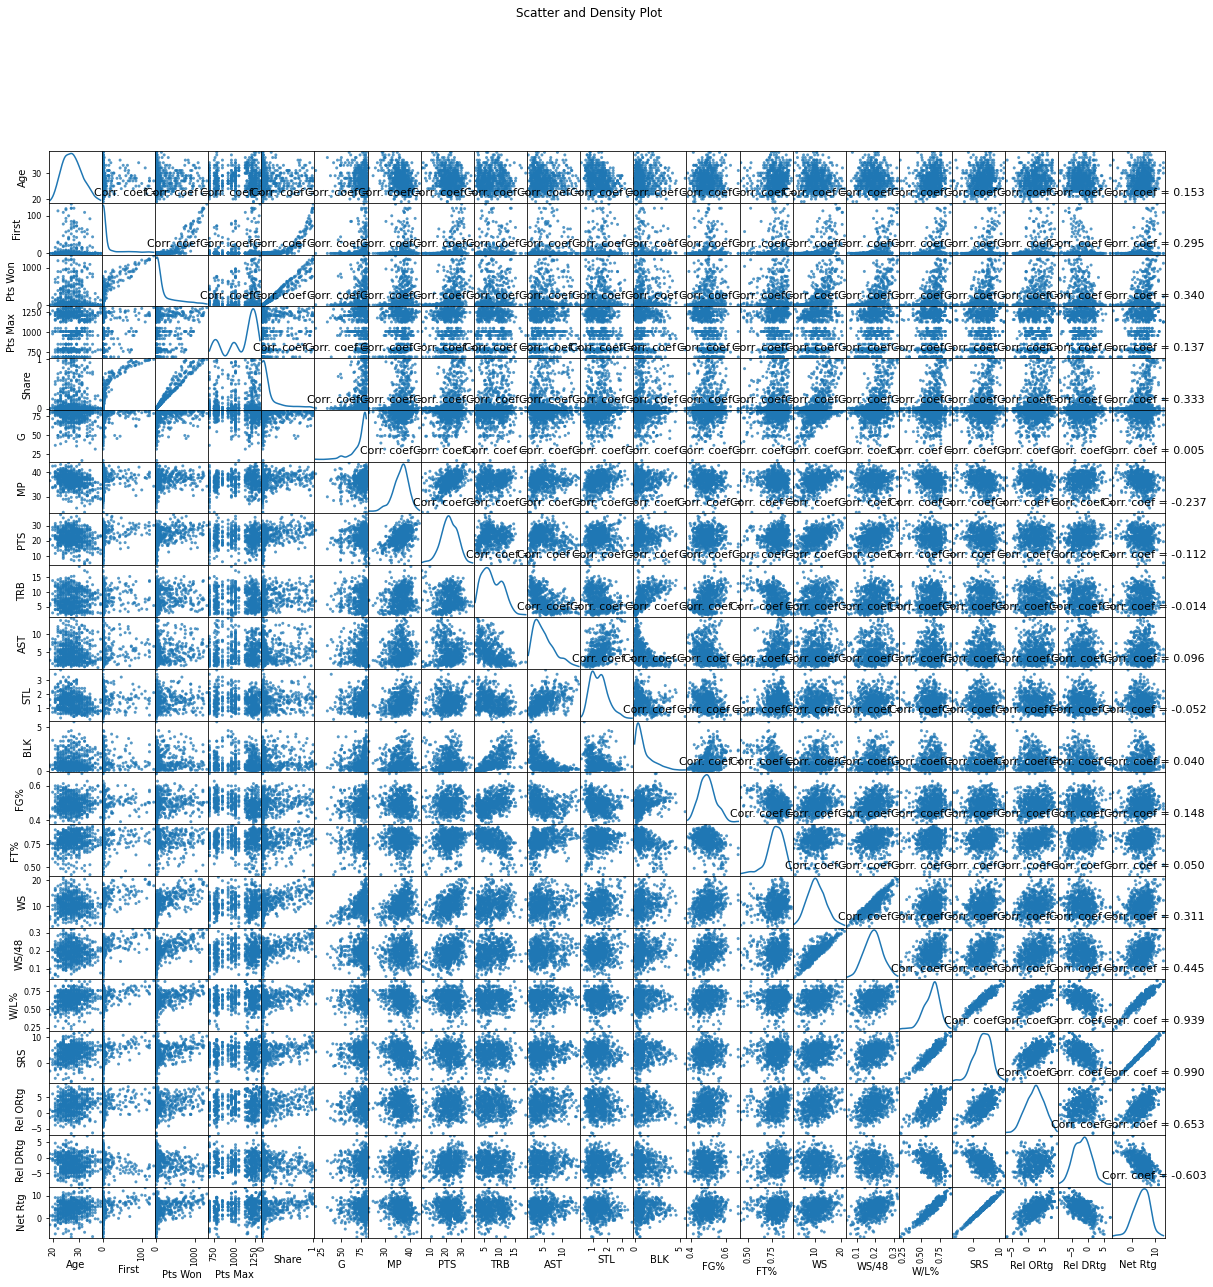

In [19]:
plotScatterMatrix(df_votes,20,11)

In [20]:
df_votes.columns

Index(['Season', 'Player', 'Age', 'Team', 'First', 'Pts Won', 'Pts Max',
       'Share', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%',
       'FT%', 'WS', 'WS/48', 'W/L%', 'SRS', 'Rel ORtg', 'Rel DRtg', 'Net Rtg'],
      dtype='object')

In [21]:
df = df_votes.drop(['Net Rtg','Player','Team','Pts Max'],axis=1)

In [22]:
df = df_votes.drop(['Pts Won','First'],axis=1)

In [23]:
y = df.Share

In [24]:
df.head()

,Season,Player,Age,Team,Pts Max,Share,G,MP,PTS,TRB,...,FG%,3P%,FT%,WS,WS/48,W/L%,SRS,Rel ORtg,Rel DRtg,Net Rtg
0,2019-20,Giannis Antetokounmpo,25,MIL,1010,0.952,63,30.4,29.5,13.6,...,0.553,0.304,0.633,11.1,0.279,0.767,9.41,1.8,-7.7,9.5
1,2019-20,LeBron James,35,LAL,1010,0.746,67,34.6,25.3,7.8,...,0.493,0.348,0.693,9.8,0.204,0.732,6.28,1.4,-4.3,5.7
2,2019-20,Anthony Davis,26,LAL,1010,0.081,62,34.4,26.1,9.3,...,0.503,0.330,0.846,11.1,0.250,0.732,6.28,1.4,-4.3,5.7
3,2019-20,James Harden,30,HOU,1010,0.363,68,36.5,34.3,6.6,...,0.444,0.355,0.865,13.1,0.254,0.611,3.13,2.3,-0.5,2.8
4,2019-20,Luka Dončić,20,DAL,1010,0.198,61,33.6,28.8,9.4,...,0.463,0.316,0.758,8.8,0.207,0.573,4.87,6.1,1.1,5.0


In [25]:
features = ['Age','G','MP','PTS','TRB','AST','STL','BLK','FG%','3P%','FT%','WS','WS/48','W/L%','SRS']

In [26]:
y.head()

0    0.952
1    0.746
2    0.081
3    0.363
4    0.198
Name: Share, dtype: float64

In [27]:
X = df[features]

In [28]:
df[features].loc

In [29]:
X.loc[:,['3P%']] = X['3P%'].fillna(0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
X.describe()

,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,W/L%,SRS
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,27.470305,74.712681,36.239647,22.097111,7.487961,5.045586,1.420546,0.989085,0.494538,0.259737,0.781122,10.719422,0.189226,0.635008,3.792119
std,3.749212,9.512352,3.056923,5.274960,3.264064,2.846837,0.583339,0.932777,0.045629,0.153742,0.088532,3.395082,0.048902,0.105041,3.175919
min,19.000000,17.000000,23.600000,4.700000,1.900000,0.800000,0.200000,0.000000,0.384000,0.000000,0.422000,2.300000,0.046000,0.220000,-7.210000
25%,25.000000,72.000000,34.500000,18.800000,4.900000,2.800000,1.000000,0.300000,0.463000,0.176000,0.738000,8.500000,0.155500,0.573000,1.750000
50%,27.000000,79.000000,36.700000,22.100000,6.900000,4.500000,1.400000,0.700000,0.493000,0.305000,0.791000,10.600000,0.190000,0.659000,4.040000
75%,30.000000,81.000000,38.200000,25.900000,10.200000,6.750000,1.800000,1.400000,0.522500,0.366000,0.844000,12.900000,0.222000,0.707000,6.180000
max,38.000000,82.000000,43.700000,37.100000,18.700000,14.500000,3.700000,5.600000,0.670000,1.000000,0.948000,21.200000,0.322000,0.890000,11.800000


In [31]:
y.describe()

count    623.000000
mean       0.163502
std        0.264488
min        0.001000
25%        0.004000
50%        0.022000
75%        0.208500
max        1.000000
Name: Share, dtype: float64

In [32]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [33]:
share_model = DecisionTreeRegressor(random_state = 0)
share_model.fit(train_X,train_y)

DecisionTreeRegressor(random_state=0)

In [34]:
print("Making predictions for the following 5 player-seasons:")
print(X.head())
print("The predictions are")
print(share_model.predict(X.head()))

Making predictions for the following 5 player-seasons:
   Age   G    MP   PTS   TRB   AST  STL  BLK    FG%    3P%    FT%    WS  \
0   25  63  30.4  29.5  13.6   5.6  1.0  1.0  0.553  0.304  0.633  11.1   
1   35  67  34.6  25.3   7.8  10.2  1.2  0.5  0.493  0.348  0.693   9.8   
2   26  62  34.4  26.1   9.3   3.2  1.5  2.3  0.503  0.330  0.846  11.1   
3   30  68  36.5  34.3   6.6   7.5  1.8  0.9  0.444  0.355  0.865  13.1   
4   20  61  33.6  28.8   9.4   8.8  1.0  0.2  0.463  0.316  0.758   8.8   

   WS/48   W/L%   SRS  
0  0.279  0.767  9.41  
1  0.204  0.732  6.28  
2  0.250  0.732  6.28  
3  0.254  0.611  3.13  
4  0.207  0.573  4.87  
The predictions are
[0.952 0.347 0.081 0.363 0.198]


In [35]:
y.head()

0    0.952
1    0.746
2    0.081
3    0.363
4    0.198
Name: Share, dtype: float64

In [36]:
print(mean_absolute_error(y,share_model.predict(X)))

0.03399518459069021


In [37]:
val_predictions = share_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

0.13576282051282051


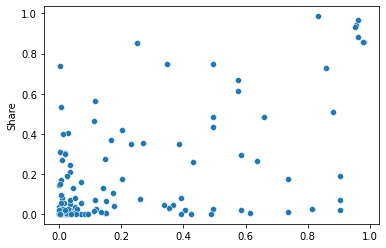

In [38]:
sn.scatterplot(x=val_predictions,y=val_y)

In [39]:
pd.Series(val_y).corr(pd.Series(val_predictions))

-0.24311797272214816

In [40]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X,train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [41]:
leaves = []
errors = []
for max_leaf_nodes in range(2,25,2):
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    leaves.append(max_leaf_nodes)
    errors.append(my_mae)
    print(f'Max leaf nodes {max_leaf_nodes} \t\t Mean Absolute Error: {my_mae}')

Max leaf nodes 2 		 Mean Absolute Error: 0.14281603613305385
Max leaf nodes 4 		 Mean Absolute Error: 0.1205391700459381
Max leaf nodes 6 		 Mean Absolute Error: 0.11790130683332326
Max leaf nodes 8 		 Mean Absolute Error: 0.11975560558016832
Max leaf nodes 10 		 Mean Absolute Error: 0.11947392563730415
Max leaf nodes 12 		 Mean Absolute Error: 0.11575749623337477
Max leaf nodes 14 		 Mean Absolute Error: 0.11750384576104007
Max leaf nodes 16 		 Mean Absolute Error: 0.12135048158136012
Max leaf nodes 18 		 Mean Absolute Error: 0.1226351198597484
Max leaf nodes 20 		 Mean Absolute Error: 0.12103667208338886
Max leaf nodes 22 		 Mean Absolute Error: 0.12468510190559916
Max leaf nodes 24 		 Mean Absolute Error: 0.12659072868622595


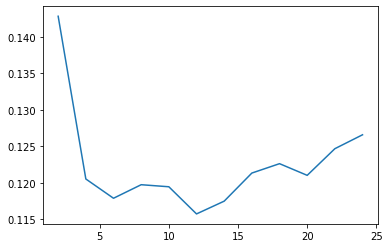

In [42]:
sn.lineplot(x=leaves,y=errors)

In [43]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
forest_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, forest_preds))

RandomForestRegressor(random_state=1)

0.10507884615384615


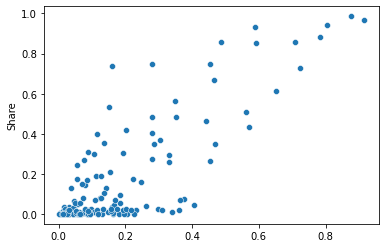

In [44]:
sn.scatterplot(x=forest_preds,y=val_y)

In [45]:
pd.Series(forest_preds).corr(pd.Series(val_y))

-0.20075061428892266

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.10301177652611716

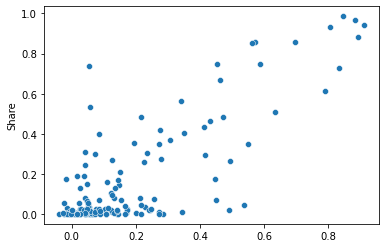

In [46]:
xgb_model = XGBRegressor()
xgb_model.fit(train_X, train_y)
predictions_xgb = xgb_model.predict(val_X)
mean_absolute_error(val_y,predictions_xgb)

sn.scatterplot(x=predictions_xgb,y=val_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.09941638358838212

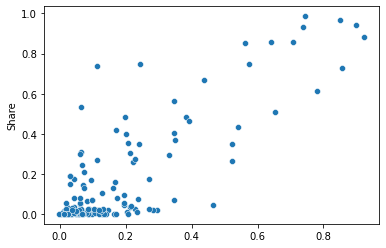

In [47]:
xgb_model = XGBRegressor(n_estimators=1000, 
                         learning_rate=.05)
xgb_model.fit(train_X, train_y, 
              early_stopping_rounds=5,
              eval_set=[(val_X, val_y)],
              verbose=False)
predictions_xgb = xgb_model.predict(val_X)
mean_absolute_error(val_y,predictions_xgb)

sn.scatterplot(x=predictions_xgb,y=val_y)

In [48]:
train_X.columns

Index(['Age', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%',
       'FT%', 'WS', 'WS/48', 'W/L%', 'SRS'],
      dtype='object')

In [49]:
lgb_train = lgb.Dataset(train_X, label=train_y)
lgb_test = lgb.Dataset(val_X, label=val_y)

In [122]:
lgb_params = {
    'objective' : 'mse',
    'n_jobs' : '2'
}

In [123]:
lgb_model = lgb.train(params=lgb_params,
                      train_set=lgb_train,
                      valid_sets=lgb_test,
                      num_boost_round=5000,
                      early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1243
[LightGBM] [Info] Number of data points in the train set: 467, number of used features: 15
[LightGBM] [Info] Start training from score 0.166737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 0.0566479
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 0.0512773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 0.0472832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 0.0435839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 0.0402384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	v

0.09921391144148392

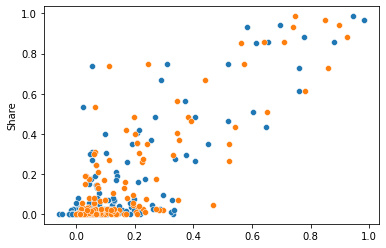

In [124]:
predictions_lgb = lgb_model.predict(val_X)
mean_absolute_error(val_y,predictions_lgb)
sn.scatterplot(x=predictions_lgb,y=val_y)
sn.scatterplot(x=predictions_xgb,y=val_y)

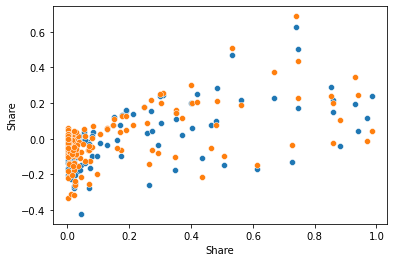

In [126]:
sn.scatterplot(x=val_y,y=val_y-predictions_xgb)
sn.scatterplot(x=val_y,y=val_y-predictions_lgb)

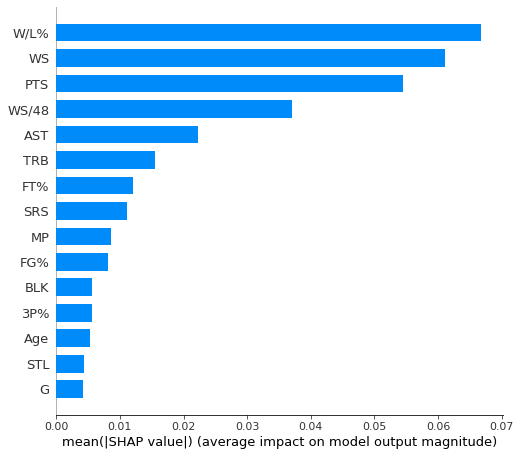

In [127]:
shap.initjs()

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values, X, plot_type='bar')

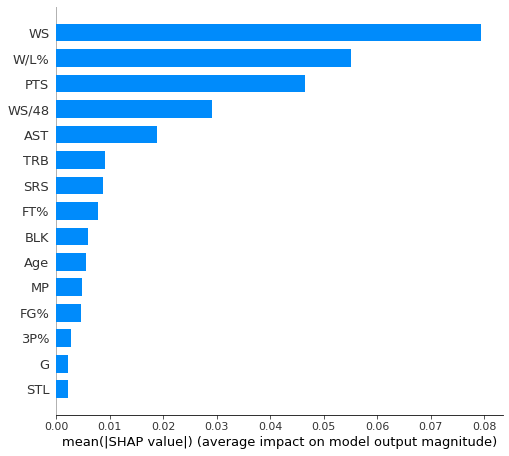

In [129]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_X)
shap.summary_plot(shap_values, X, plot_type='bar')

In [113]:
df_votes['Predicted Share lgb'] = pd.DataFrame(lgb_model.predict(X))
df_votes['Predicted Share xgb'] = pd.DataFrame(xgb_model.predict(X))

In [59]:

df_votes['Season'].unique()

array(['2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15',
       '2013-14', '2012-13', '2011-12', '2010-11', '2009-10', '2008-09',
       '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03',
       '2001-02', '2000-01', '1999-00', '1998-99', '1997-98', '1996-97',
       '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91',
       '1989-90', '1988-89', '1987-88', '1986-87', '1985-86', '1984-85',
       '1983-84', '1982-83', '1981-82', '1980-81'], dtype=object)

In [60]:
a = df_votes['Season'].unique()[1]

In [61]:
df_votes.iloc[2]

Season                       2019-20
Player                 Anthony Davis
Age                               26
Team                             LAL
First                            0.0
Pts Won                         82.0
Pts Max                         1010
Share                          0.081
G                                 62
MP                              34.4
PTS                             26.1
TRB                              9.3
AST                              3.2
STL                              1.5
BLK                              2.3
FG%                            0.503
3P%                             0.33
FT%                            0.846
WS                              11.1
WS/48                           0.25
W/L%                           0.732
SRS                             6.28
Rel ORtg                         1.4
Rel DRtg                        -4.3
Net Rtg                          5.7
Predicted Share lgb         0.092583
Predicted Share xgb         0.137125
N

In [62]:
df_votes.query(f'Season == "2018-19"').loc[13]

Season                      2018-19
Player                 James Harden
Age                              29
Team                            HOU
First                          23.0
Pts Won                       776.0
Pts Max                        1010
Share                         0.768
G                                78
MP                             36.8
PTS                            36.1
TRB                             6.6
AST                             7.5
STL                             2.0
BLK                             0.7
FG%                           0.442
3P%                           0.368
FT%                           0.879
WS                             15.2
WS/48                         0.254
W/L%                          0.646
SRS                            4.96
Rel ORtg                        5.1
Rel DRtg                        0.3
Net Rtg                         4.8
Predicted Share lgb        0.618114
Predicted Share xgb        0.732777
Name: 13, dtype: object

In [63]:
df_votes.head()

,Season,Player,Age,Team,First,Pts Won,Pts Max,Share,G,MP,...,FT%,WS,WS/48,W/L%,SRS,Rel ORtg,Rel DRtg,Net Rtg,Predicted Share lgb,Predicted Share xgb
0,2019-20,Giannis Antetokounmpo,25,MIL,85.0,962.0,1010,0.952,63,30.4,...,0.633,11.1,0.279,0.767,9.41,1.8,-7.7,9.5,0.443841,0.897175
1,2019-20,LeBron James,35,LAL,16.0,753.0,1010,0.746,67,34.6,...,0.693,9.8,0.204,0.732,6.28,1.4,-4.3,5.7,0.142952,0.243909
2,2019-20,Anthony Davis,26,LAL,0.0,82.0,1010,0.081,62,34.4,...,0.846,11.1,0.250,0.732,6.28,1.4,-4.3,5.7,0.092583,0.137125
3,2019-20,James Harden,30,HOU,0.0,367.0,1010,0.363,68,36.5,...,0.865,13.1,0.254,0.611,3.13,2.3,-0.5,2.8,0.424051,0.374660
4,2019-20,Luka Dončić,20,DAL,0.0,200.0,1010,0.198,61,33.6,...,0.758,8.8,0.207,0.573,4.87,6.1,1.1,5.0,0.153576,0.187063


In [114]:
winners = pd.DataFrame()
mvps = []

for season in df_votes['Season'].unique():
    ballot = df_votes.query(f'Season == @season')
    mvp_lgb = ballot['Player'].iloc[ballot['Predicted Share lgb'].argmax()]
    mvp_xgb = ballot['Player'].iloc[ballot['Predicted Share xgb'].argmax()]
    mvp = ballot['Player'].iloc[ballot['Share'].argmax()]
    mvps.append([season, mvp, mvp_lgb, mvp_xgb])
    
    

In [118]:
lgb_correct = [1 if _lgb == true else 0 for __,true, _lgb, _ in mvps]
xgb_correct = [1 if _xgb == true else 0 for __,true, _, _xgb in mvps]
sum(lgb_correct)
sum(xgb_correct)

34

37

In [116]:
mvps_T = list(map(list, zip(*mvps))) #transpose results for table

In [79]:
colors = n_colors('rgb(100, 0, 0)', 'rgb(0, 100, 0)', 2, colortype='rgb')

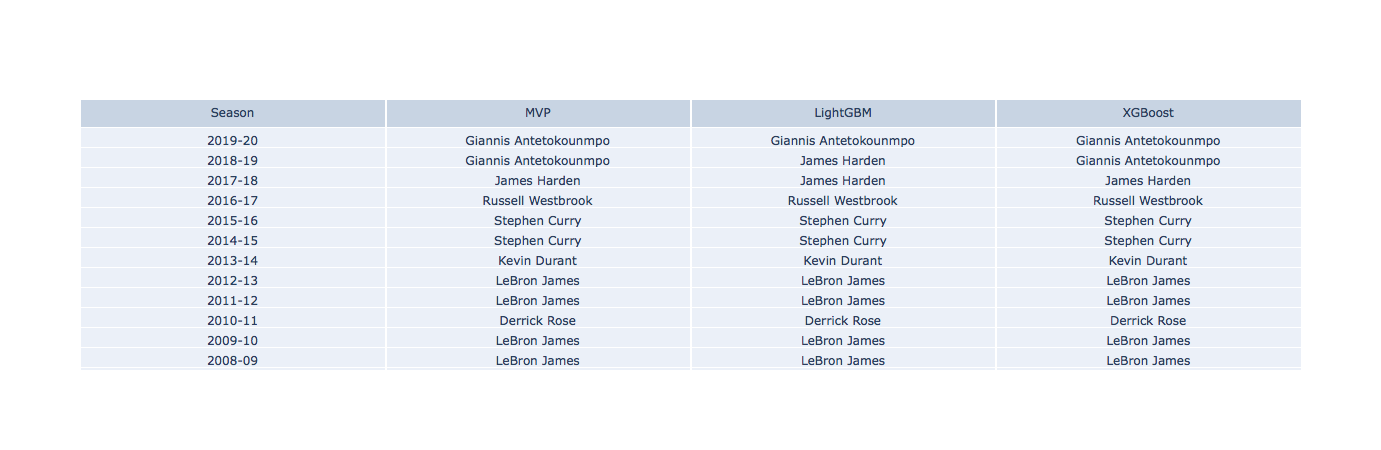

In [117]:
fig = go.Figure(data=[go.Table(header=dict(values=['Season', 'MVP', 'LightGBM', 'XGBoost']),
                                cells=dict(values=mvps_T)),                      
                     ])
fig.show()  

In [119]:
df_votes.query('Season == "1992-93"')

,Season,Player,Age,Team,First,Pts Won,Pts Max,Share,G,MP,...,FT%,WS,WS/48,W/L%,SRS,Rel ORtg,Rel DRtg,Net Rtg,Predicted Share lgb,Predicted Share xgb
385,1992-93,Charles Barkley,29,PHO,59.0,835.0,980,0.852,76,37.6,...,0.765,14.4,0.242,0.756,6.27,5.3,-1.3,6.6,0.613950,0.563265
386,1992-93,Hakeem Olajuwon,30,HOU,22.0,647.0,980,0.660,82,39.5,...,0.779,15.8,0.234,0.671,3.57,1.6,-2.8,4.4,0.506795,0.620436
387,1992-93,Michael Jordan,29,CHI,13.0,565.0,980,0.577,78,39.3,...,0.837,17.2,0.270,0.695,6.19,4.9,-1.9,6.8,0.813171,0.598048
388,1992-93,Patrick Ewing,30,NYK,4.0,359.0,980,0.366,81,37.1,...,0.719,10.6,0.170,0.732,5.87,-1.9,-8.3,6.4,0.282683,0.310942
389,1992-93,Dominique Wilkins,33,ATL,0.0,54.0,980,0.055,71,37.3,...,0.828,10.5,0.191,0.524,-0.67,1.3,2.2,-0.9,0.051732,0.051887
390,1992-93,David Robinson,27,SAS,0.0,33.0,980,0.034,82,39.2,...,0.732,13.2,0.197,0.598,2.21,1.6,-1.2,2.8,0.043608,0.089265
391,1992-93,Shaquille O'Neal,20,ORL,0.0,30.0,980,0.031,81,37.9,...,0.592,10.4,0.163,0.500,1.35,0.5,-0.9,1.4,0.042550,0.041747
392,1992-93,Karl Malone,29,UTA,0.0,10.0,980,0.010,82,37.8,...,0.740,15.4,0.238,0.573,1.74,1.6,-0.6,2.2,0.321965,0.235139
393,1992-93,John Stockton,30,UTA,0.0,1.0,980,0.001,82,34.9,...,0.798,10.6,0.177,0.573,1.74,1.6,-0.6,2.2,0.049592,0.022730
394,1992-93,Mark Price,28,CLE,0.0,10.0,980,0.010,75,31.7,...,0.948,9.8,0.197,0.659,6.30,4.7,-2.0,6.7,-0.014016,0.021162


In [80]:
df_votes.query('Season == "2005-06"')

,Season,Player,Age,Team,First,Pts Won,Pts Max,Share,G,MP,...,FT%,WS,WS/48,W/L%,SRS,Rel ORtg,Rel DRtg,Net Rtg,Predicted Share lgb,Predicted Share xgb
187,2005-06,Steve Nash,31,PHO,57.0,924.0,1250,0.739,79,35.4,...,0.921,12.4,0.212,0.659,5.48,5.3,-0.4,5.7,0.042144,0.112322
188,2005-06,Shawn Marion,27,PHO,0.0,1.0,1250,0.001,81,40.3,...,0.809,14.6,0.214,0.659,5.48,5.3,-0.4,5.7,0.027219,0.045373
189,2005-06,LeBron James,21,CLE,16.0,688.0,1250,0.550,79,42.5,...,0.738,16.3,0.232,0.610,2.17,1.6,-0.8,2.4,0.549750,0.543424
190,2005-06,Dirk Nowitzki,27,DAL,14.0,544.0,1250,0.435,81,38.1,...,0.901,17.7,0.275,0.732,5.96,5.6,-1.2,6.8,0.793149,0.541554
191,2005-06,Kobe Bryant,27,LAL,22.0,483.0,1250,0.386,80,41.0,...,0.850,15.3,0.224,0.549,2.53,2.2,-0.5,2.7,0.385190,0.397509
192,2005-06,Chauncey Billups,29,DET,15.0,430.0,1250,0.344,81,36.1,...,0.894,15.5,0.254,0.780,6.24,4.6,-3.1,7.7,0.347277,0.351119
193,2005-06,Dwyane Wade,24,MIA,0.0,87.0,1250,0.070,75,38.6,...,0.783,14.4,0.239,0.634,3.59,2.5,-1.7,4.2,0.356112,0.347754
194,2005-06,Elton Brand,26,LAC,1.0,50.0,1250,0.040,79,39.2,...,0.775,14.8,0.229,0.573,1.75,-0.9,-2.6,1.7,0.107854,0.215572
195,2005-06,Tim Duncan,29,SAS,0.0,33.0,1250,0.026,80,34.8,...,0.629,10.8,0.187,0.768,6.69,1.1,-6.6,7.7,0.101469,0.090586
196,2005-06,Tony Parker,23,SAS,0.0,9.0,1250,0.007,80,33.9,...,0.707,9.6,0.169,0.768,6.69,1.1,-6.6,7.7,0.019747,0.080089
